<a href="https://colab.research.google.com/github/YannickVroonland/IDA-code/blob/main/TM23_IDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM2.3 - IDA GGZ Drenthe

# Imports

In [ ]:
## Import packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy import stats
from statistics import mean
from statistics import stdev
from statistics import mode
from collections import Counter
from google.colab import files

## Data loading and preparation

In [ ]:
## Import the necessary data files by uploading them in the panel on the left
df_IDA = pd.read_excel('TM2.3_IDA_final.xlsx') # file with data on all patients
df_0 = pd.read_excel('TM2.3_IDA_noIDpatients.xlsx') # file with no-ID patients only
df_1 = pd.read_excel('TM2.3_IDA_IDpatients.xlsx') # file with ID patients only

# Calculation of the % empty cells per parameter
df_complete_nan = (df_IDA.isnull().sum(axis = 0))/(len(df_IDA))*100


# Splitting data from the ID label
y_labels = df_IDA['ID label']
x_data = df_IDA.drop(['ID label', 'ID anoniem', 'Medication usage'], axis=1) # Medication usage is dropped because only the ATC codes and the sum of medications is used at this point

# Make a CSV file with the % empty cells for all parameters
df_complete_nan.to_csv('IDA_nans.csv', encoding = 'utf-8-sig') 
files.download('IDA_nans.csv') #<-- uncomment this line to download the CSV file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Baseline characteristics

In [ ]:
## Age distribution

age_0 = df_0.pop('Leeftijd')
age_1 = df_1.pop('Leeftijd')
mean_age_0 = np.round(age_0.mean(), decimals=2) # Mean age in no-ID group
std_age_0 = np.round(age_0.std(), decimals=2) # STD of the age in no-ID group
mean_age_1 = np.round(age_1.mean(), decimals=2) # Mean age in the ID group
std_age_1 = np.round(age_1.std(), decimals=2) # STD of the age in the ID group
mean_std = [mean_age_0, std_age_0, mean_age_1, std_age_1]
print(mean_std) # Print the results in the same order as above

[41.16, 16.51, 32.25, 13.55]


In [ ]:
## Gender distribution

female = ((df_IDA['Geslacht']=='v').sum(axis = 0))/(len(df_IDA))*100
female_noID = ((df_0['Geslacht']=='v').sum(axis = 0))/(len(df_0))*100
female_ID = ((df_1['Geslacht']=='v').sum(axis = 0))/(len(df_1))*100
# Uncomment one of the lines below to show the % females in total or in each group
#print(female)
print(female_noID)
print(female_ID)

60.0
40.74074074074074


## Data preprocessing

In [ ]:
## Transformation of categorical parameters to binary dummy parameters

dummies_occupation = x_data["Occupation"].str.get_dummies(", ")
#dummies_education = x_data["Finished education"].str.get_dummies(", ") <-- uncomment and add to pd.concat below when used.
dummies_logical = x_data["Type of logical issues"].str.get_dummies(", ")
dummies_relation = x_data["Relationships"].str.get_dummies(", ")
dummies_BMI = x_data["BMI"].str.get_dummies(", ")
dummies_hospitalisation = x_data["Hospitalisation (aantal)"].str.get_dummies(", ")
dummies_som_disc = x_data["Number of somatic disciplines involved"].str.get_dummies(", ")
dummies_gender = x_data["Geslacht"].str.get_dummies(", ")
# The next commented lines do not work properly yet. The goal is to filter out the diagnoses that were predefined by dr. Laura de Graaff
# as being potentially more frequent in ID patients. Drop all other diagnoses, but leave the total sum of the diagnoses as a parameter. 
# This way, the number of parameter can be reduced, while keeping the parameters that are thought to be most relevant.
# NB: the list of relevant diagnoses was originally longer, but some diagnoses were not found in the current data set and therefore removed from the list to prevent errors.
dummies_medhist1 = x_data['Medical history ICD-10'].str.get_dummies(", ") # dummies of all diagnoses in the data set
#list_to_pop = ['autism','epilepsy','ADHD','hypertension','diabetes','gastrointestinal','urogenital','syndrome','sleep problems']
#dummies_medhist.col = [dummies_medhist1.pop(col) for col in list_to_pop] 
dummies_medication = x_data["Medication usage ATC"].str.get_dummies(", ")
dummies_muscskel = x_data["Musculoskeletal problems"].str.get_dummies(", ")
dummies_behaviour = x_data["Behaviour"].str.get_dummies(", ")
# Combine all dummies into one dataframe
dummies = pd.concat([dummies_medhist1, dummies_muscskel, dummies_som_disc, dummies_gender, dummies_hospitalisation, dummies_occupation, dummies_logical, dummies_relation, dummies_BMI, dummies_medication, dummies_behaviour], axis=1)
# Drop the original parameters that were transformed
x_data = x_data.drop(columns=["Occupation", "Hospitalisation (aantal)", "Geslacht", "Number of somatic disciplines involved", "Medical history ICD-10", "Finished education", "Type of logical issues", "Relationships", "BMI", "Medical history", "Medication usage ATC", "Musculoskeletal problems", "Behaviour"])
# Combine the dummies and the other parameters
x_data = pd.concat([x_data, dummies], axis=1)
print('The number of features after transformation to dummies is: ' + str(len(x_data.columns)))

The number of features after transformation to dummies is: 179


In [ ]:
## Train - test split, stratified for ID/no ID

x_train, x_test, y_train, y_test = train_test_split(x_data, y_labels, test_size=0.1, random_state=42, stratify=y_labels)
train1 = pd.concat([x_train, y_train], axis=1) # Concatenate the data with the ID labels again

# Remove duplicate columns that resulted from the same entries existing in multiple columns in the original data set
train = train1.loc[:, ~train1.columns.duplicated()]

In [ ]:
## Sorting the different types of parameters 
continuous_keys = ['Height','Systolic blood pressure','Diastolic blood pressure']
binary_keys1 = ['Psychological problems', 'Logical issues', 'Visual impairment', 'Hearing impairment', 'Adapted footware/mobiliteit', 'Currently smoking', 'Past smoking', 'Currently alcohol', 'Past alcohol', 'Currently drugs', 'Past drugs', 'Ineffective treatment', 'Remarkibility in speech, vocab, or speech impediment']
ordinal_keys = ['Aantal as 1', 'Aantal as 2','Sum medical history','Sum medication']
binary_keys2 = list(dummies.columns)
binary_keys = binary_keys2 + binary_keys1
len(binary_keys) # Show the number of binary keys

170

## Data analysis

### Continuous parameters

In [ ]:
## Imputation of continuous parameters with a 3-nearest neighbours imputer
height = x_train.pop('Height')
syst = x_train.pop('Systolic blood pressure')
diast = x_train.pop('Diastolic blood pressure')
x_train_cont = pd.concat([height, syst, diast], axis=1)
imputer = KNNImputer(n_neighbors=3, weights="distance")
x_train_cont = pd.DataFrame(imputer.fit_transform(x_train_cont), columns=list(x_train_cont.columns), index=list(x_train.index))
x_train_cont = pd.concat([x_train_cont, y_train], axis=1)

## Test continuous parameters for significance with Mann-Whitney U tests
x_train_cont_ID = x_train_cont[x_train_cont['ID label'] == 1] # make dataframe with ID patients
x_train_cont_noID = x_train_cont[x_train_cont['ID label'] == 0] # make dataframe with no-ID patients
df_p_cont = pd.DataFrame({'Features': x_train_cont.columns}) # Dataframe for p-values

for column_name in x_train_cont.columns:
  U1,p_cont = mannwhitneyu(x_train_cont_ID[column_name],x_train_cont_noID[column_name]) # Mann-Whitney U test for each parameter
  df_p_cont.loc[df_p_cont['Features'] == column_name, 'P-value'] = p_cont
  df_p_cont_sorted = df_p_cont.sort_values(by=['P-value'])    # Sort the values by p-values
  df_p_cont_sorted['Rank'] = range(1, len(df_p_cont_sorted)+1)    # Rank the features
  df_p_cont_sorted['Significance level'] = 0.05/(len(df_p_cont_sorted)+1-df_p_cont_sorted['Rank'])    # Calculate the significance level per feature
  df_p_cont_sorted['Significant'] = np.where(df_p_cont_sorted['P-value'] < df_p_cont_sorted['Significance level'], 'Yes', 'No')    # Find which features are significant

df_p_cont_sorted.head()

,Features,P-value,Rank,Significance level,Significant
3,ID label,2.425460e-42,1,0.012500,Yes
1,Systolic blood pressure,3.583386e-01,2,0.016667,No
0,Height,4.549230e-01,3,0.025000,No
2,Diastolic blood pressure,8.825228e-01,4,0.050000,No


In [ ]:
# Download a CSV file with the p-values for the continuous parameters
df_p_cont_sorted.to_csv('IDA_continuous_MWU.csv', encoding = 'utf-8-sig') 
#files.download('IDA_continuous_MWU.csv') #<-- uncomment this line to download

### Ordinal parameters

In [ ]:
# Fill remaining empty values
x_train = x_train.fillna(0)
train = train.fillna(0)

## Make dataframe with ordinal parameters
as1 = x_train.pop('Aantal as 1')
as2 = x_train.pop('Aantal as 2') #-1 here because axis 2 has 1 inclusion criterion that could throw off the predictive value
sum_medhist = x_train.pop('Sum medical history')
sum_medication = x_train.pop('Sum medication')
x_train_ord = pd.concat([as1, as2, sum_medhist, sum_medication, y_train], axis=1)

## Test ordinal parameters for significance
x_train_ord_ID = x_train_ord[x_train_ord['ID label'] == 1]
x_train_ord_noID = x_train_ord[x_train_ord['ID label'] == 0]
df_p_ord = pd.DataFrame({'Features': x_train_ord.columns})

for column_name in x_train_ord.columns:
  U1,p_ord = mannwhitneyu(x_train_ord_ID[column_name],x_train_ord_noID[column_name])
  df_p_ord.loc[df_p_ord['Features'] == column_name, 'P-value'] = p_ord
  df_p_ord_sorted = df_p_ord.sort_values(by=['P-value'])    # Sort the values by p-values
  df_p_ord_sorted['Rank'] = range(1, len(df_p_ord_sorted)+1)    # Rank the features
  df_p_ord_sorted['Significance level'] = 0.05/(len(df_p_ord_sorted)+1-df_p_ord_sorted['Rank'])    # Calculate the significance level per feature
  df_p_ord_sorted['Significant'] = np.where(df_p_ord_sorted['P-value'] < df_p_ord_sorted['Significance level'], 'Yes', 'No')    # Find which features are significant

print(df_p_ord)

              Features       P-value
0          Aantal as 1  1.016355e-02
1          Aantal as 2  1.627271e-01
2  Sum medical history  4.942755e-01
3       Sum medication  8.107554e-01
4             ID label  2.425460e-42


In [ ]:
df_p_ord_sorted.head()

,Features,P-value,Rank,Significance level,Significant
4,ID label,2.425460e-42,1,0.010000,Yes
0,Aantal as 1,1.016355e-02,2,0.012500,Yes
1,Aantal as 2,1.627271e-01,3,0.016667,No
2,Sum medical history,4.942755e-01,4,0.025000,No
3,Sum medication,8.107554e-01,5,0.050000,No


In [ ]:
#Download a CVS file with p-values for ordinal parameters
df_p_ord_sorted.to_csv('IDA_ordinal_MWU.csv', encoding = 'utf-8-sig') 
#files.download('IDA_ordinal_MWU.csv') #<-- uncomment for download

### Binary parameters

In [ ]:
# Make dataframe with all binary parameters
df_p_bin = pd.DataFrame({'Features': binary_keys})
sign_features_dfs = pd.DataFrame(columns = ['Features'])
for key in binary_keys:
        _, p_bin, _, _ = chi2_contingency(pd.crosstab(train['ID label'], train[key]))   # Perform the Chi square test
        df_p_bin.loc[df_p_bin['Features'] == key, 'P-value'] = p_bin  # Fill dataframe with p-values
        df_p_bin_sorted = df_p_bin.sort_values(by=['P-value'])    # Sort the values by p-values
        df_p_bin_sorted['Rank'] = range(1, len(df_p_bin_sorted)+1)    # Rank the features
        df_p_bin_sorted['Significance level'] = 0.05/(len(df_p_bin_sorted)+1-df_p_bin_sorted['Rank'])    # Calculate the significance level per feature
        df_p_bin_sorted['Significant'] = np.where(df_p_bin_sorted['P-value'] < df_p_bin_sorted['Significance level'], 'Yes', 'No')    # Find which features are significant
        # Create dataframe with significant features only and create table for visualisation
        df_p_bin_sign = df_p_bin_sorted.loc[df_p_bin_sorted['Significant'] == 'Yes']
        df_p_for_table = df_p_bin_sign 
        # Append the dataframe with significant features to a list for every fold. In this list, the dataframes for the 5 folds are stored.
        sign_features_dfs = sign_features_dfs.append(df_p_for_table)
        # Create list of significant features that can be used for model creation
        sign = df_p_bin_sign['Features'].tolist()

print(df_p_bin_sign)


<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)
<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)
<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)
<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)
<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append meth

        Features   P-value  Rank  Significance level Significant
65  dagbesteding  0.000012     1            0.000294         Yes
85       married  0.000064     2            0.000296         Yes


<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)
<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)
<ipython-input-13-217c2129425b>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sign_features_dfs = sign_features_dfs.append(df_p_for_table)


In [ ]:
# Make and download a CSV file with the results for all binary parameters
df_p_bin_sorted.to_csv('TM2.3_IDA_significance_binary.csv', encoding = 'utf-8-sig')
#files.download('TM2.3_IDA_significance_binary.csv')
df_p_bin_sorted

,Features,P-value,Rank,Significance level,Significant
65,dagbesteding,0.000012,1,0.000294,Yes
85,married,0.000064,2,0.000296,Yes
87,single,0.000919,3,0.000298,No
52,0,0.003283,4,0.000299,No
59,0,0.003283,5,0.000301,No
...,...,...,...,...,...
113,D07,1.000000,166,0.010000,No
112,D04,1.000000,167,0.012500,No
46,rugklachten,1.000000,168,0.016667,No
132,R01,1.000000,169,0.025000,No


In [ ]:
x_train = pd.concat([x_train, x_train_ord, x_train_cont], axis=1)
# BMI and gender are dropped because they are not used for the model at this point
# BMI needs to be transformed from numerical to categorical first (underweight, normal, overweight, obese)
#x_train = x_train.drop('BMI', axis=1)
#x_train = x_train.drop('Gender', axis=1)

## 4. Machine Learning model

In [ ]:
## Preparing the test set
# Performing all preprocessing steps on the test set
height_test = x_test.pop('Height')
syst_test = x_test.pop('Systolic blood pressure')
diast_test = x_test.pop('Diastolic blood pressure')
x_test_cont = pd.concat([height_test, syst_test, diast_test], axis=1)
imputer = KNNImputer(n_neighbors=3, weights="distance")
x_test_cont = pd.DataFrame(imputer.fit_transform(x_test_cont), columns=continuous_keys, index=list(x_test.index))
x_test = x_test.fillna(0)

as1_test = x_test.pop('Aantal as 1')
as2_test = x_test.pop('Aantal as 2')
sum_medhist_test = x_test.pop('Sum medical history')
sum_medication_test = x_test.pop('Sum medication')
x_test_ord = pd.concat([as1_test, as2_test, sum_medhist_test, sum_medication_test], axis=1)

x_test = pd.concat([x_test, x_test_ord, x_test_cont], axis=1)
#x_test = x_test.drop('BMI', axis=1)
x_train = x_train.drop('ID label', axis=1)
#x_test = x_test.drop('Geslacht', axis=1)

In [ ]:
x_train.fillna(value=0,inplace=True)
y_train.fillna(value=0,inplace=True)
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_train.head(-20)

,Justitial contacts,Psychological problems,Logical issues,Visual impairment,Hearing impairment,Adapted footware/mobiliteit,Currently smoking,Past smoking,Currently alcohol,Past alcohol,...,sexually inappropriate,verbal aggression,verbal agression,Aantal as 1,Aantal as 2,Sum medical history,Sum medication,Height,Systolic blood pressure,Diastolic blood pressure
0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,2,0,2,4,164.000000,142.000000,106.000000
1,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,9,6,175.295323,110.000000,60.000000
2,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,4,0,177.681818,127.531915,80.957447
3,0.0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,3,0,1,1,177.681818,127.531915,80.957447
4,0.0,1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,1,1,177.681818,127.531915,80.957447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,1,198.000000,147.000000,76.000000
163,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,3,0,3,1,177.681818,127.531915,80.957447
164,0.0,1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,1,0,1,2,177.681818,127.531915,80.957447
165,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,1,1,177.681818,127.531915,80.957447


In [ ]:
## Fit and test a Random Forest classifier

clf = RandomForestClassifier()
clf.fit(x_train, y_train)
total_trees = 20
max_depth = 5
predicted = clf.predict(x_test)
roc_auc = metrics.roc_auc_score(y_test, predicted)
roc_auc

# Calculate performance measures
tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()   # Find the true negatives, false positives, false negatives and true positives from the confusion matrix
spec = tn/(tn+fp) # Specificity
sens = tp/(tp+fn) # Sensitivity
accuracy = metrics.accuracy_score(y_test, predicted) # Accuracy
f1 = metrics.f1_score(y_test, predicted) # F1-score
print([spec, sens, accuracy, f1]) # Print all performance measures in the order as above

[0.7, 0.9090909090909091, 0.8095238095238095, 0.8333333333333333]


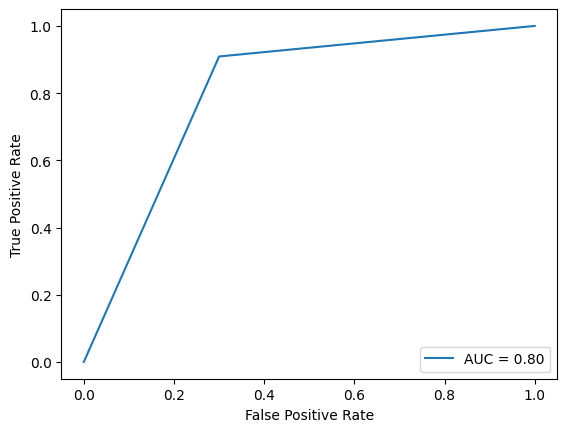

In [ ]:
## Plot Receiver Operator Characteristic Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

Feature selection